#### Import Statements 

In [ ]:
import pandas as pd
import numpy as np
from numpy.fft import fft, fftfreq, ifftn
import matplotlib.pyplot as plt
from scipy import fftpack 
from scipy import signal
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


#### Reading Data 

In [ ]:
#Reading data
dataframe = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/CSIRO/iladata.csv")
dataframe2 =pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/CSIRO/iladata_m10dBm.csv")
dataframe.head(3)

Sample in Buffer  ... design_1_i/usp_rf_data_converter_0_m23_axis_tvalid
0  Radix - UNSIGNED  ...                                                HEX
1                 0  ...                                                  1
2                 1  ...                                                  1

[3 rows x 11 columns]

In [ ]:
# Adjusting the index 
dataframe = dataframe.drop(dataframe.index[[0]])
dataframe = dataframe.reset_index(drop = True)
dataframe.head(9)

Sample in Buffer  ... design_1_i/usp_rf_data_converter_0_m23_axis_tvalid
0                0  ...                                                  1
1                1  ...                                                  1
2                2  ...                                                  1
3                3  ...                                                  1
4                4  ...                                                  1
5                5  ...                                                  1
6                6  ...                                                  1
7                7  ...                                                  1
8                8  ...                                                  1

[9 rows x 11 columns]

In [ ]:
# ADC input
adc_01 = dataframe[['Sample in Buffer', 'Sample in Window', 'TRIGGER', 'design_1_i/usp_rf_data_converter_0_m20_axis_tdata[63:0]', 'design_1_i/usp_rf_data_converter_0_m20_axis_tvalid']]
adc_02 = dataframe[['Sample in Buffer', 'Sample in Window', 'TRIGGER', 'design_1_i/usp_rf_data_converter_0_m21_axis_tdata[63:0]', 'design_1_i/usp_rf_data_converter_0_m21_axis_tvalid']]
adc_03 = dataframe[['Sample in Buffer', 'Sample in Window', 'TRIGGER', 'design_1_i/usp_rf_data_converter_0_m22_axis_tdata[63:0]', 'design_1_i/usp_rf_data_converter_0_m21_axis_tvalid']]
adc_04 = dataframe[['Sample in Buffer', 'Sample in Window', 'TRIGGER', 'design_1_i/usp_rf_data_converter_0_m23_axis_tdata[63:0]', 'design_1_i/usp_rf_data_converter_0_m21_axis_tvalid']]

### Function to convert hex to 2's complement value or signed int

In [ ]:
# to convert hex to binary
def hex_bin(dataframe):
  dataframe['Sample_1'] = dataframe['Sample_1'].apply(int , base=16)
  dataframe['Sample_2'] = dataframe['Sample_2'].apply(int , base=16)
  dataframe['Sample_3'] = dataframe['Sample_3'].apply(int , base=16)
  dataframe['Sample_4'] = dataframe['Sample_4'].apply(int , base=16)
  
  dataframe['Sample_1'] = dataframe['Sample_1'].apply(bin)
  dataframe['Sample_2'] = dataframe['Sample_2'].apply(bin)
  dataframe['Sample_3'] = dataframe['Sample_3'].apply(bin)
  dataframe['Sample_4'] = dataframe['Sample_4'].apply(bin)

  dataframe['Sample_1'] = dataframe['Sample_1'].str[2:]
  dataframe['Sample_2'] = dataframe['Sample_2'].str[2:]
  dataframe['Sample_3'] = dataframe['Sample_3'].str[2:]
  dataframe['Sample_4'] = dataframe['Sample_4'].str[2:]

In [ ]:
# to convert hex to signed int
def get_signedInt(x):
   # 0x7FFF = 32767
   if int(x,2) > 0x7FFF:
    N = int(x, 2)
    #65535 is the total range a signed int can handle 
    TC = (-1)*(65535 + 1 - N)          
    return TC
   else :
    return int(x,2)

### Function to split the combined hex value into 4 samples

In [ ]:
def split_samples(dataframe, column):
  dataframe['Sample_1'] = dataframe[column].str[0:4]
  dataframe['Sample_2'] = dataframe[column].str[4:8]
  dataframe['Sample_3'] = dataframe[column].str[8:12]
  dataframe['Sample_4'] = dataframe[column].str[12:16]
  dataframe

### Function to convert hexadecimal Data into Signed int and order the columns

In [ ]:
def data_signed_int(df, column_name):
  df[column_name] = df[column_name].astype('|S')  # Converting into String Format
  split_samples(df,column_name)                   # Splitting samples
  hex_bin(df)                                     # Converting hex to binary format

  # For every sample get the signed int format 
  for i in range(len(adc_01)):
    df['Sample_1'].iloc[i] = get_signedInt(df['Sample_1'].iloc[i])
    df['Sample_2'].iloc[i] = get_signedInt(df['Sample_2'].iloc[i])
    df['Sample_3'].iloc[i] = get_signedInt(df['Sample_3'].iloc[i])
    df['Sample_4'].iloc[i] = get_signedInt(df['Sample_4'].iloc[i])
 
  visualise_signals = df[["Sample in Buffer", "Sample_1", "Sample_2", "Sample_3", "Sample_4"]] # Minimising the columns 
  var_names = ("Sample_1", "Sample_2", "Sample_3", "Sample_4") # Combining all the Samples (Signed_int format) to var_names
  newdataframe = visualise_signals.melt(id_vars="Sample in Buffer", value_name="var_names", ignore_index=False) # creating a column named var_names
  newdataframe = newdataframe.sort_index() # Sorting Index 

  # Categorical data to numerical format
  var = {'Sample_1': 1,'Sample_2': 2, 'Sample_3':3, 'Sample_4' :4}  
  newdataframe['variable'] = [var[item] for item in newdataframe.variable] 
  newdataframe = pd.DataFrame(newdataframe)
  newdataframe = newdataframe.reset_index()

  # Sorting both the index and Samples
  newdataframe = newdataframe.sort_values(by=['index' , 'variable'], ascending=[True,True])
  newdataframe = newdataframe.reset_index()
  return newdataframe[['var_names']]

### ADC-Input 1




In [ ]:
df1 = data_signed_int(adc_01, 'design_1_i/usp_rf_data_converter_0_m20_axis_tdata[63:0]')
df1.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

(16384, 1)

Text(0, 0.5, 'Digital Output')

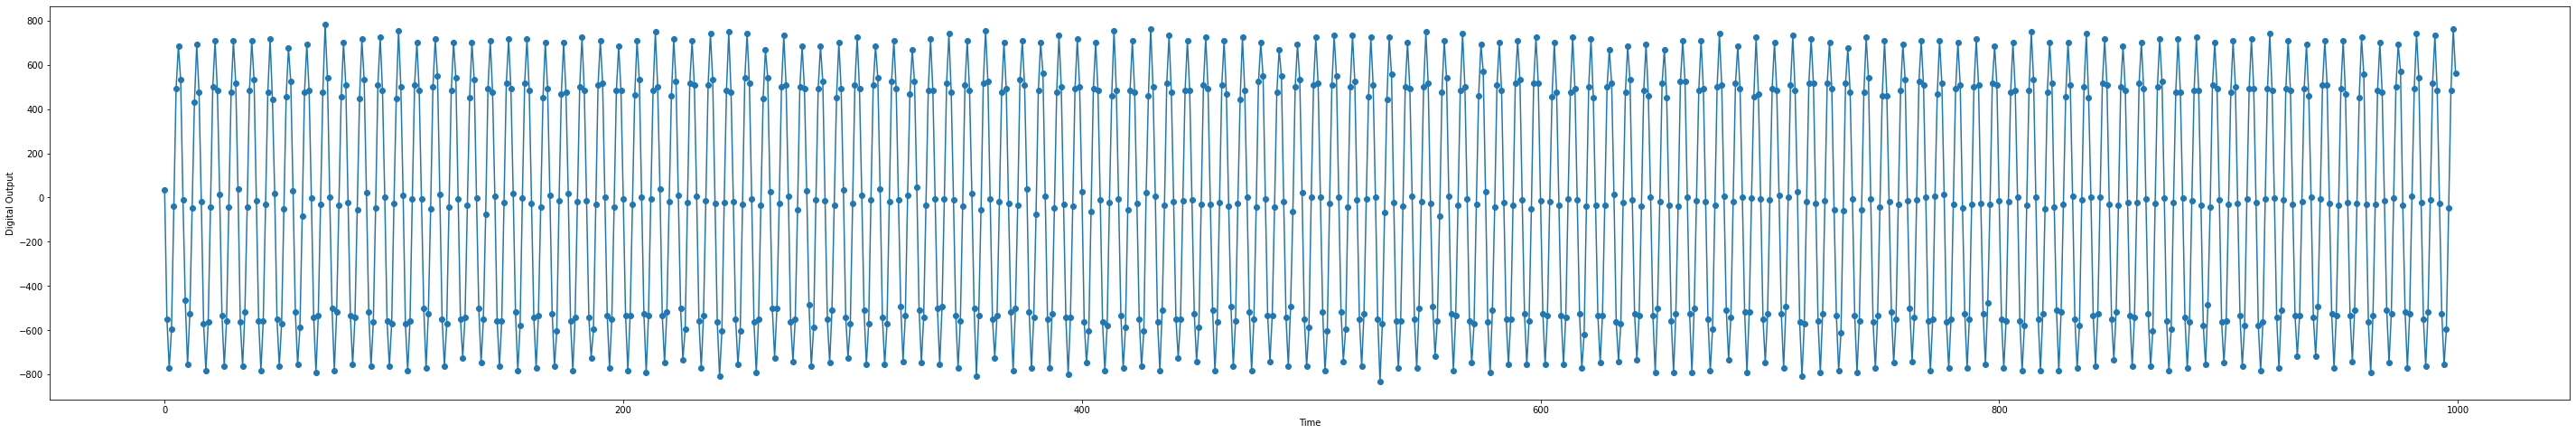

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 50
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.plot(df1[:1000], marker='o')
plt.xlabel("Time")
plt.ylabel("Digital Output")

In [ ]:
# Maximum Value, Min value, Standard deviation and mean values 
print("Maximum Value = ", df1.max())
print("Minimum value = ", df1.min())
print("Standard deviation = ", np.std(df1))
print("Mean = ", np.mean(df1))

Maximum Value =  var_names    784.0
dtype: float64
Minimum value =  var_names   -832.0
dtype: float64
Standard deviation =  var_names    521.398751
dtype: float64
Mean =  var_names   -21.874023
dtype: float64


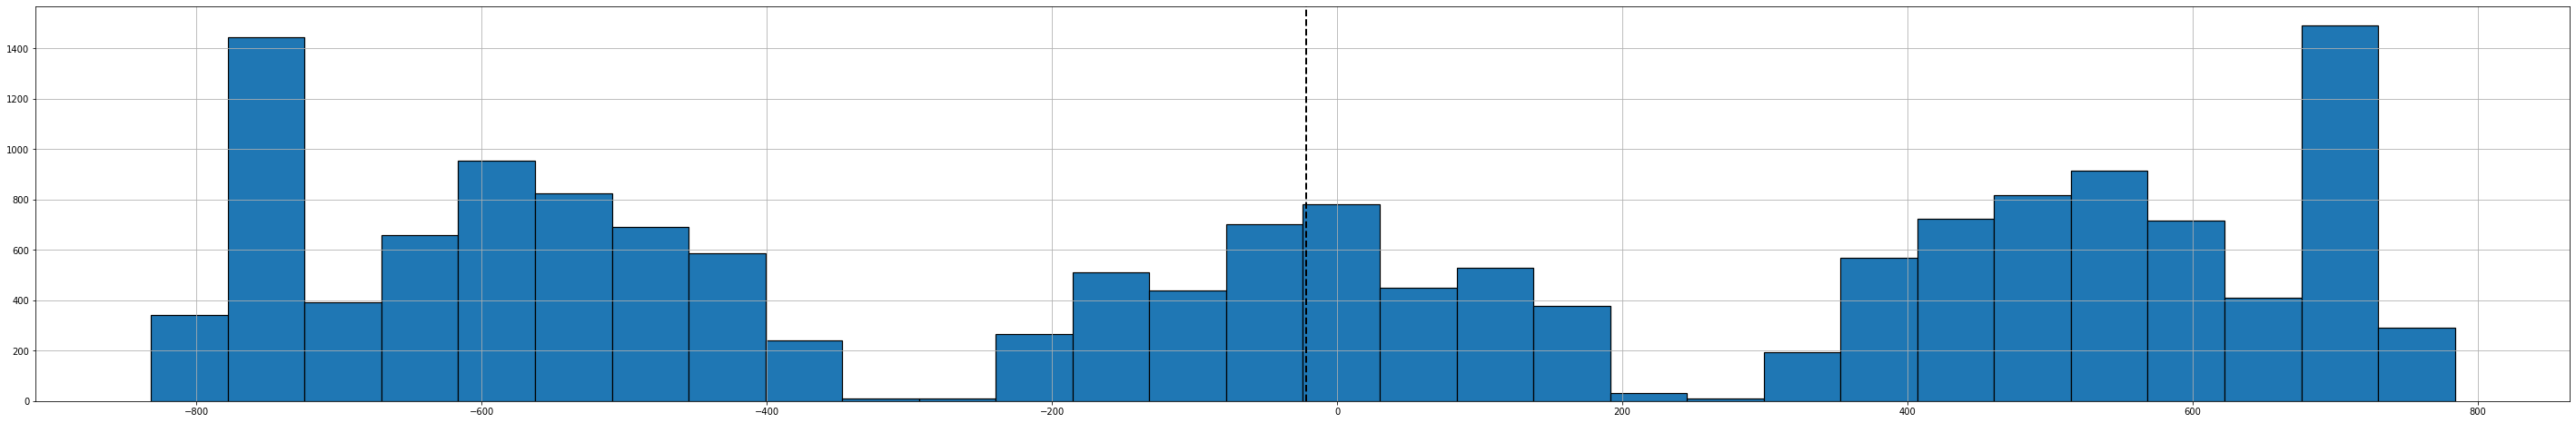

In [ ]:
df1['var_names'].hist(edgecolor= 'black', linewidth=1.2, bins=30)
plt.axvline(np.mean(df1['var_names']), color='k', linestyle='dashed', linewidth=2)

### ADC Input-2

In [ ]:
df2 = data_signed_int(adc_02, 'design_1_i/usp_rf_data_converter_0_m21_axis_tdata[63:0]')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Text(0, 0.5, 'Digital Output')

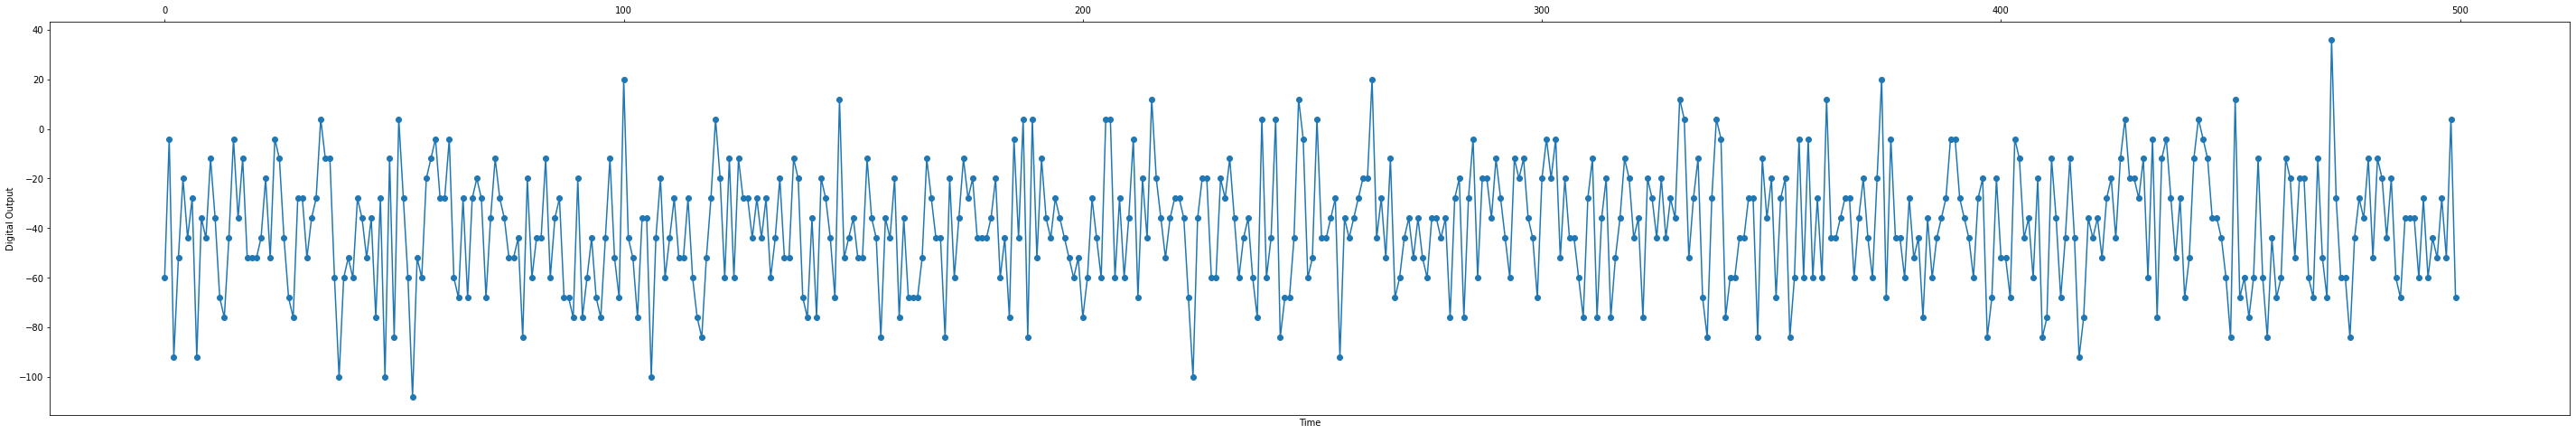

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 50
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.plot(df2[:500], marker='o')
plt.xlabel("Time")
plt.ylabel("Digital Output")


In [ ]:
# Maximum Value, Min value, Standard deviation and mean values 
print("Maximum Value = ", df2.max())
print("Minimum value = ", df2.min())
print("Standard deviation = ", np.std(df2))
print("Mean = ", np.mean(df2))

Maximum Value =  var_names    60.0
dtype: float64
Minimum value =  var_names   -124.0
dtype: float64
Standard deviation =  var_names    23.744138
dtype: float64
Mean =  var_names   -41.171387
dtype: float64


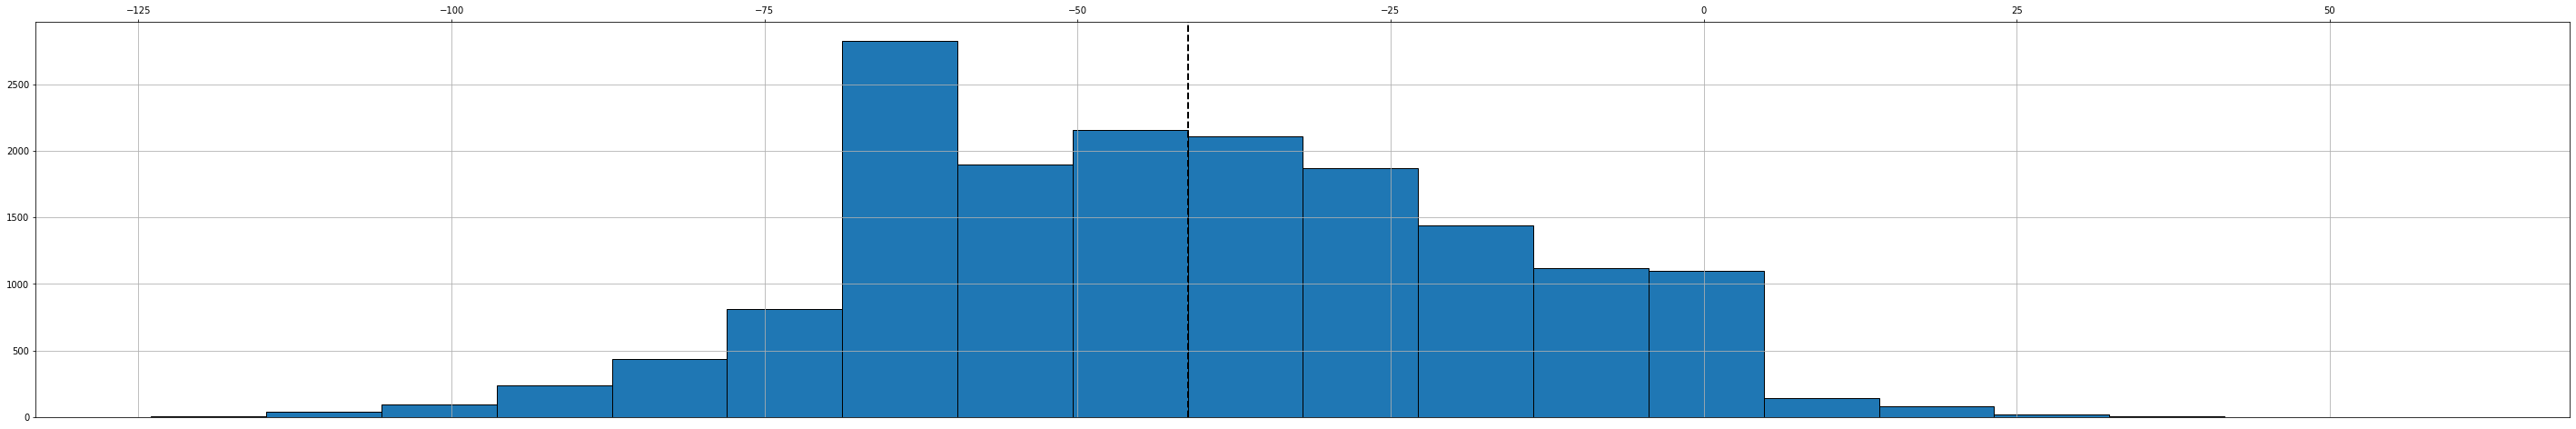

In [ ]:
df2['var_names'].hist(edgecolor='k', bins=20)
plt.axvline(np.mean(df2['var_names']), color='k', linestyle='dashed', linewidth=2)

### ADC-Input 3

In [ ]:
df3 = data_signed_int(adc_03, 'design_1_i/usp_rf_data_converter_0_m22_axis_tdata[63:0]')
df3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

var_names
0            -4
1             4
2           -28
3           -12
4           -20
...         ...
16379        20
16380       -20
16381       -44
16382        -4
16383       -12

[16384 rows x 1 columns]

Text(0, 0.5, 'Voltage')

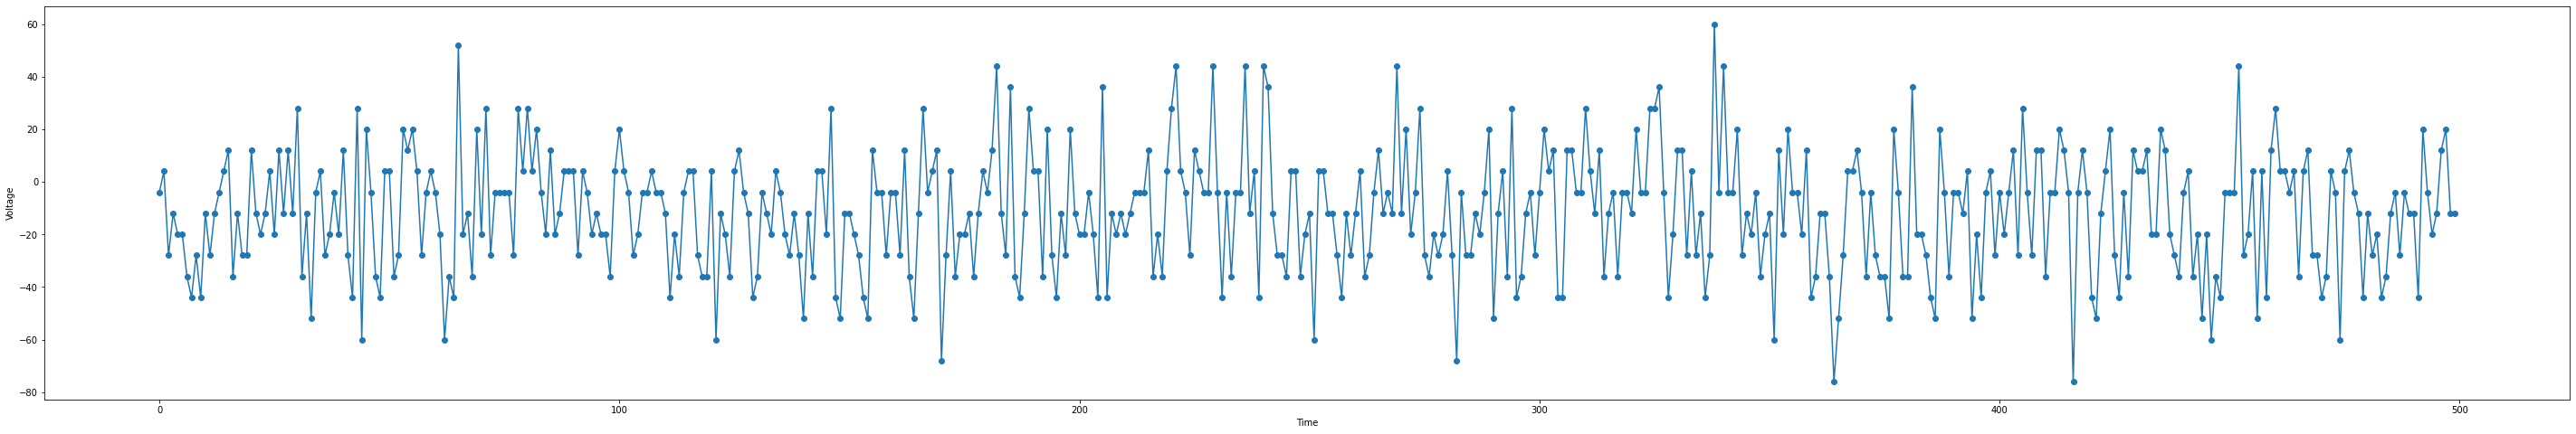

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 50
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
plt.plot(df3[:500], marker='o')
plt.xlabel("Time")
plt.ylabel("Voltage")

In [ ]:
# Maximum Value, Min value, Standard deviation and mean values 
print("Maximum Value = ", df3.max())
print("Minimum value = ", df3.min())
print("Standard deviation = ", np.std(df3))
print("Mean = ", np.mean(df3))

Maximum Value =  var_names    76.0
dtype: float64
Minimum value =  var_names   -116.0
dtype: float64
Standard deviation =  var_names    23.6695
dtype: float64
Mean =  var_names   -16.167969
dtype: float64


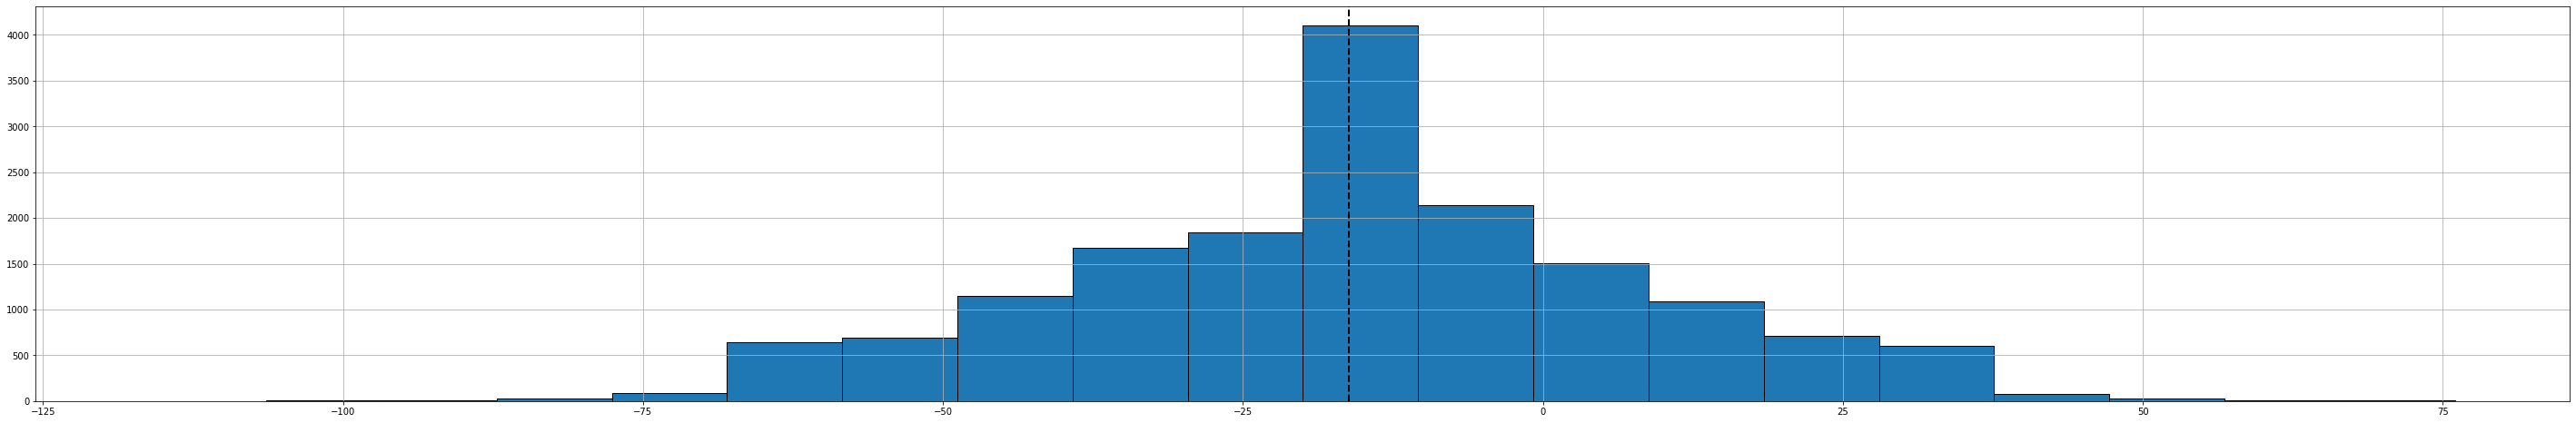

In [ ]:
df3['var_names'].hist(edgecolor = 'black', bins=20)
plt.axvline(np.mean(df3['var_names']), color='k', linestyle='dashed', linewidth=2)

### ADC - Input - 4

In [ ]:
df4 = data_signed_int(adc_04, 'design_1_i/usp_rf_data_converter_0_m23_axis_tdata[63:0]')
df4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

var_names
0           -28
1            -4
2            -4
3            -4
4           -36
...         ...
16379       -16
16380       -28
16381        44
16382       -52
16383        -4

[16384 rows x 1 columns]

Text(0, 0.5, 'Voltage')

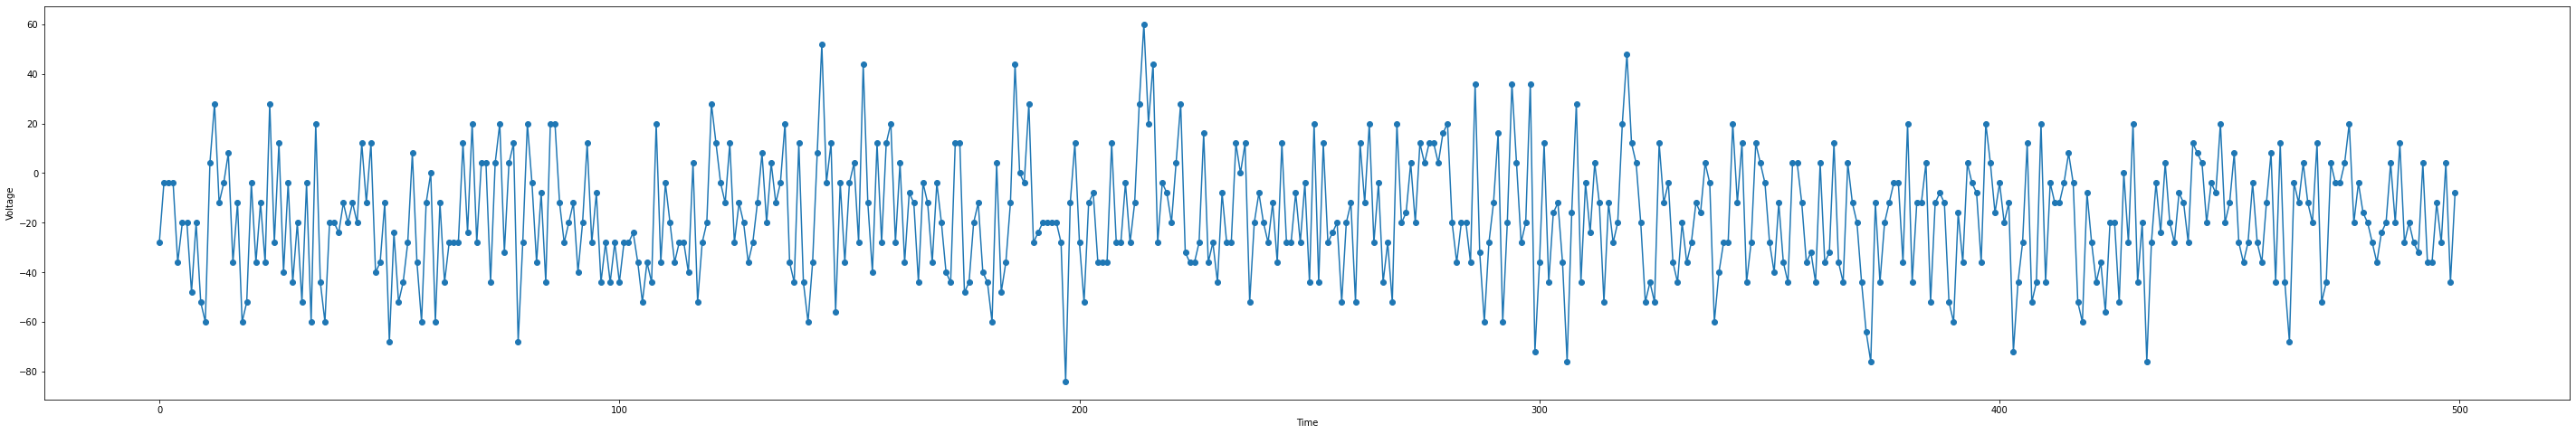

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 50
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.plot(df4[:500], marker='o')
plt.xlabel("Time")
plt.ylabel("Voltage")

In [ ]:
# Maximum Value, Min value, Standard deviation and mean values 
print("Maximum Value = ", df4.max())
print("Minimum value = ", df4.min())
print("Standard deviation = ", np.std(df4))
print("Mean = ", np.mean(df4))

Maximum Value =  var_names    68.0
dtype: float64
Minimum value =  var_names   -100.0
dtype: float64
Standard deviation =  var_names    23.439463
dtype: float64
Mean =  var_names   -19.426514
dtype: float64


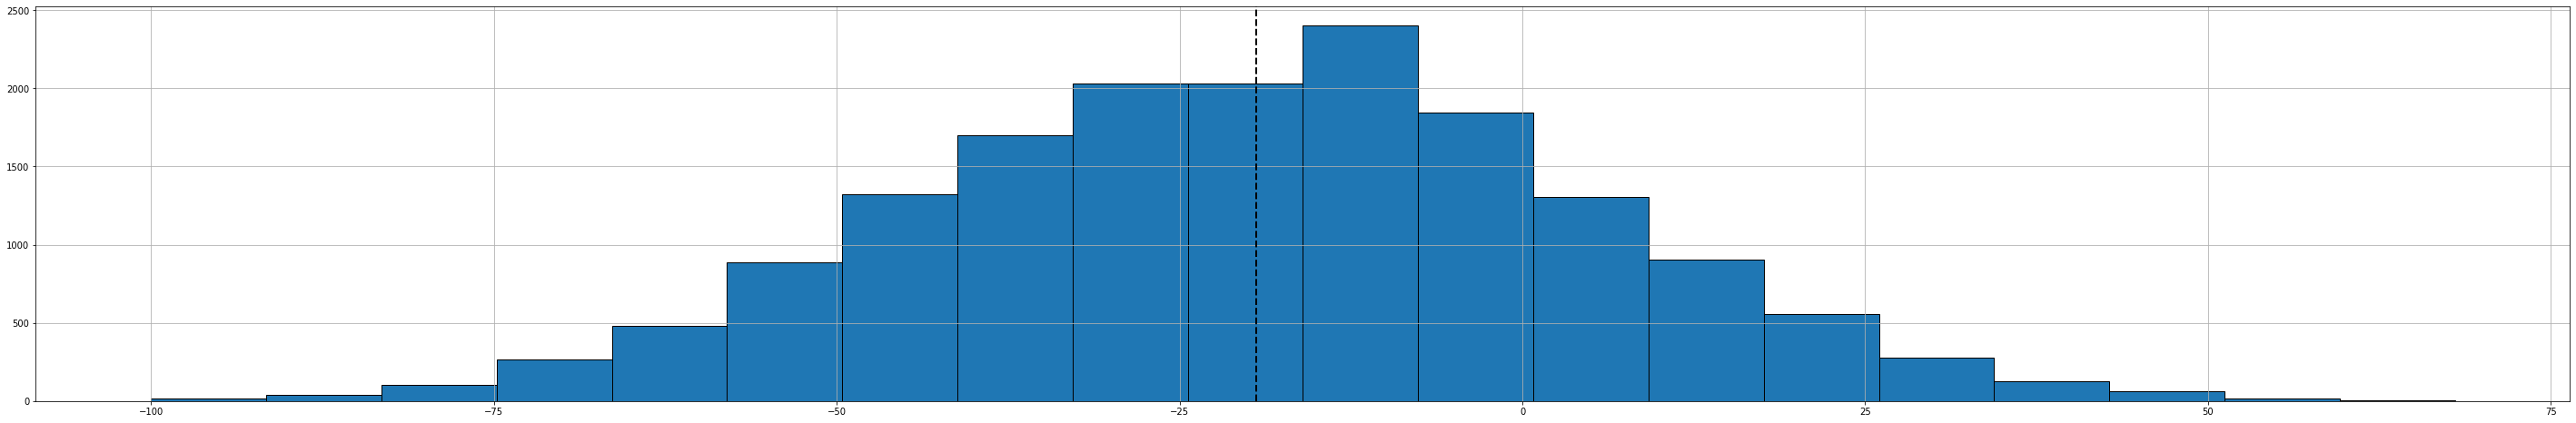

In [ ]:
df4['var_names'].hist(edgecolor='black', bins=20)
plt.axvline(np.mean(df4['var_names']), color='k', linestyle='dashed', linewidth=2)

### FFT on ADC Input Data

In [ ]:
# Sampling Frequency and Time_step 
sampling_frequency = 2*1000000000    # 2*10e9 = 2GHz/sec
time_step = 1/sampling_frequency 

# Generating Spectogram 
M=1024

#### Understanding FFT by generating 2 pure tone signals

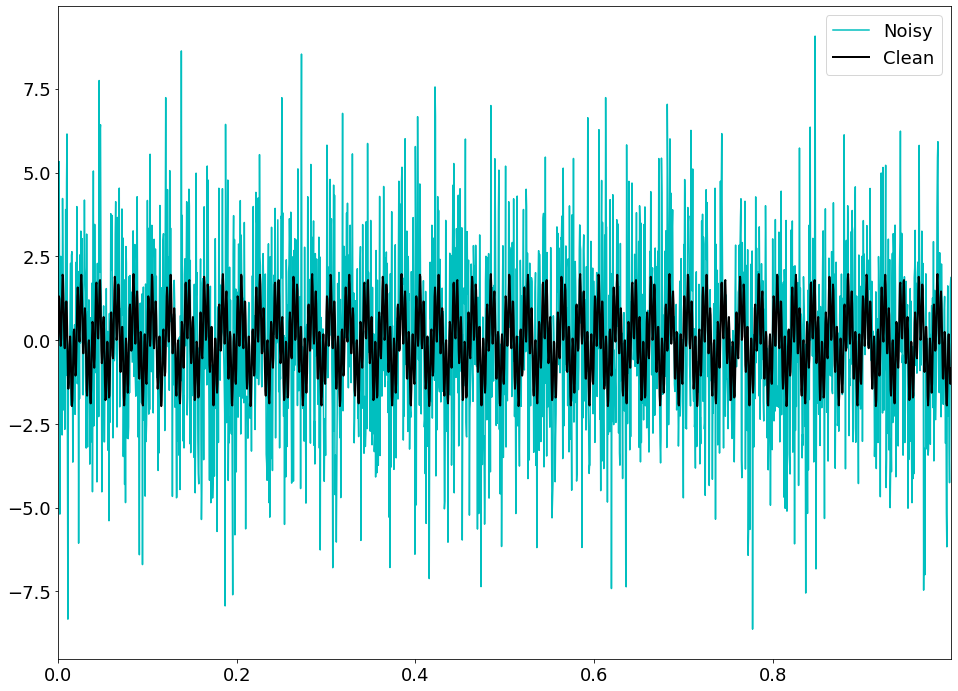

In [ ]:
plt.rcParams['figure.figsize'] = [16,12]
plt.rcParams.update({'font.size' : 18})

# creating a signal with two frequencies (2 pure tone sine waves)
step_time = 0.0005 
t = np.arange(0,1,step_time)
f = np.sin(50*2.0*np.pi*t) + np.sin(240 * 2.0*np.pi*t)
f_clean = f
f = f+ 2.5*np.random.randn(len(t)) # adding random noise with magnitude 2.5

# Plotting clean and noisy signal
plt.plot(t,f,color='c', LineWidth=1.5, label='Noisy')
plt.plot(t,f_clean,color='k', LineWidth=2, label='Clean')
plt.xlim(t[0],t[-1])
plt.legend()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


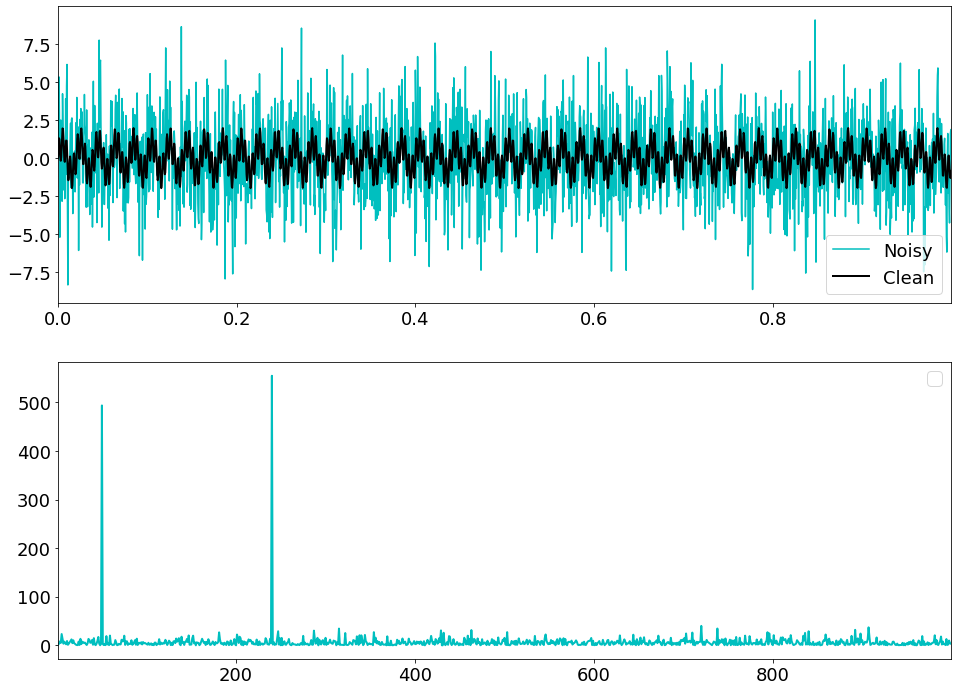

In [ ]:
# Compute Fourier Transform 

n= len(t)
fhat = np.fft.fft(f,n)   # Computing fft, fhat= fourier complex values with magnitude and phase coefficient
PSD = fhat*np.conj(fhat)/n # Power Spectral Density, we are going to get a vector of powers at each frequencies
freq=(1/(step_time*n))*np.arange(n) # Creating X-axis of frequencies
L=np.arange(1,np.floor(n/2),dtype='int')

fig,ax = plt.subplots(2,1)
plt.sca(ax[0])
plt.plot(t,f,color='c', LineWidth=1.5, label='Noisy')
plt.plot(t,f_clean,color='k', LineWidth=2, label='Clean')
plt.xlim(t[0], t[-1])
plt.legend()


plt.sca(ax[1])
plt.plot(freq[L],PSD[L],color='c', LineWidth=2)
plt.xlim(freq[L[0]], freq[L[-1]])
plt.legend()
plt.show()

#### Understanding Windowing Function

In [ ]:
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt

fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

In [ ]:
x.shape

(100000,)

In [ ]:
f, t, Sxx = signal.spectrogram(x, fs)

In [ ]:
Sxx.shape

(129, 446)

In [ ]:
f.shape

(129,)

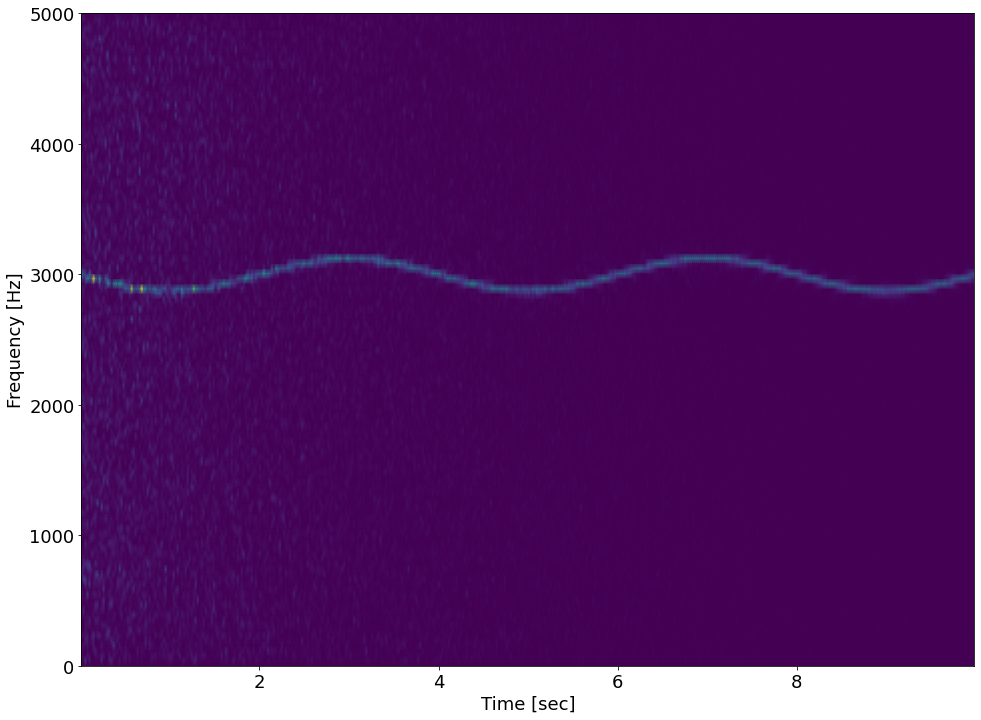

In [ ]:

plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

#### FFT on ADC_01

##### DFT

In [ ]:
# Using FFT to calculate DFT 
y = df1['var_names']
c = fftpack.fft(y)  # returns DFT of real or complex sequences
f = np.fft.fftfreq(len(y),time_step)

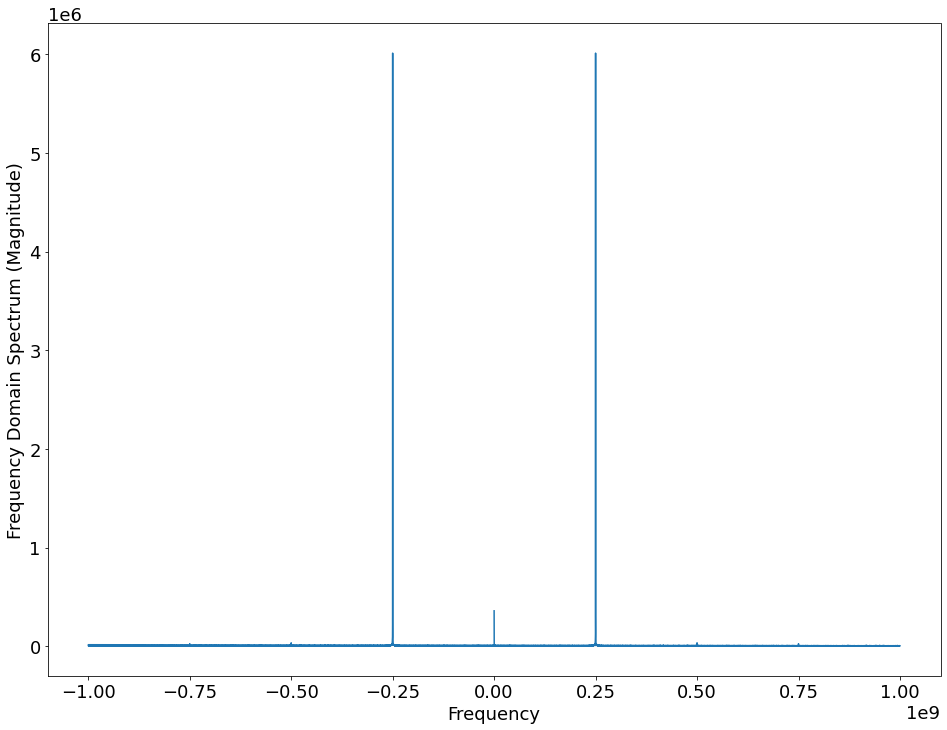

In [ ]:
# scale factor for y-axis in terms of 1x10^6
plt.plot(f,abs(c))
plt.xlabel('Frequency')
plt.ylabel('Frequency Domain Spectrum (Magnitude)')
plt.show()

##### Inverse Fourier Transform

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


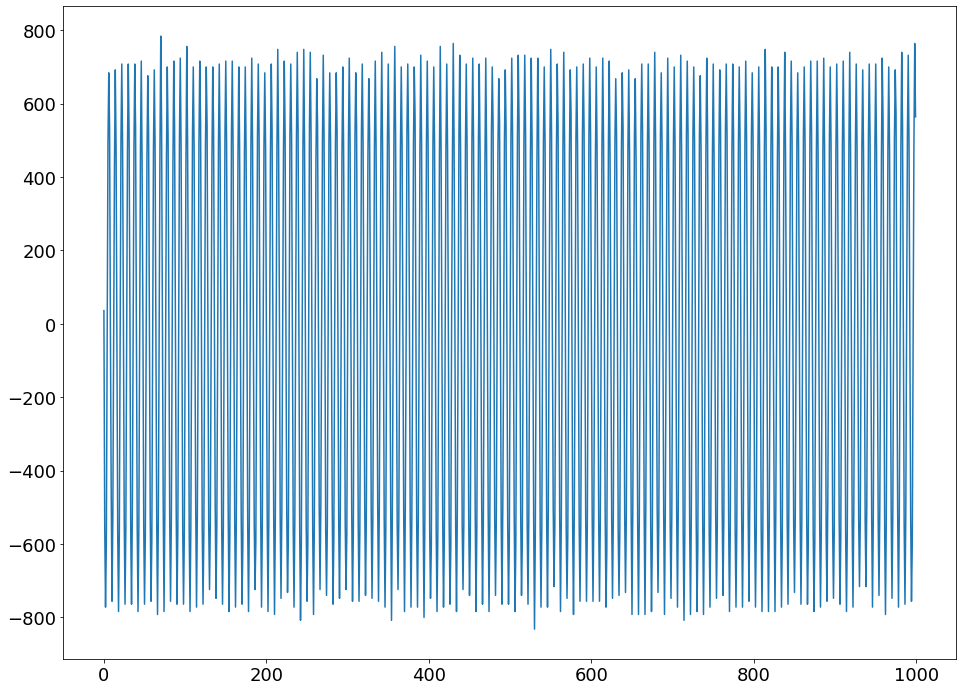

In [ ]:
# Inverse Fourier Transform
y_forInversefft = fftpack.ifft(c)
plt.plot(y_forInversefft[:1000])
plt.show()

##### Spectogram 

In [ ]:
df1 = df1['var_names']
slice1 = np.array(df1, dtype=float)
slice1.shape

(16384,)

In [ ]:
freqs, times, Sx = signal.spectrogram(slice1, fs=sampling_frequency, nperseg=1024, noverlap=512, window='hanning', return_onesided=True)

In [ ]:
freqs.shape

(513,)

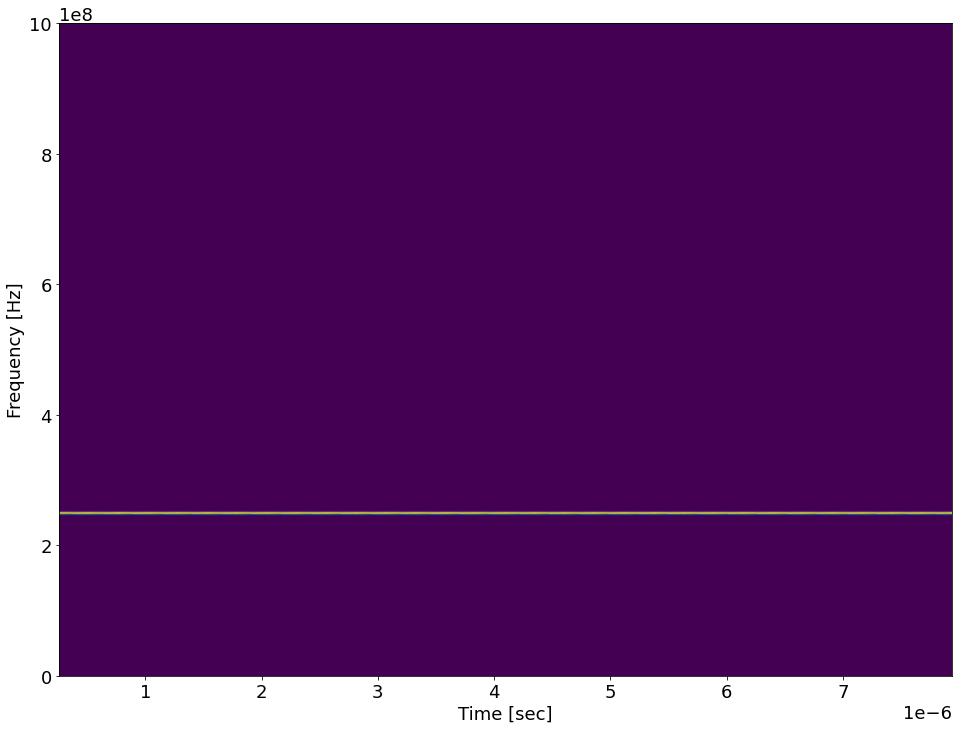

In [ ]:
plt.pcolormesh(times, freqs, Sx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

##### Power Spectral Density 

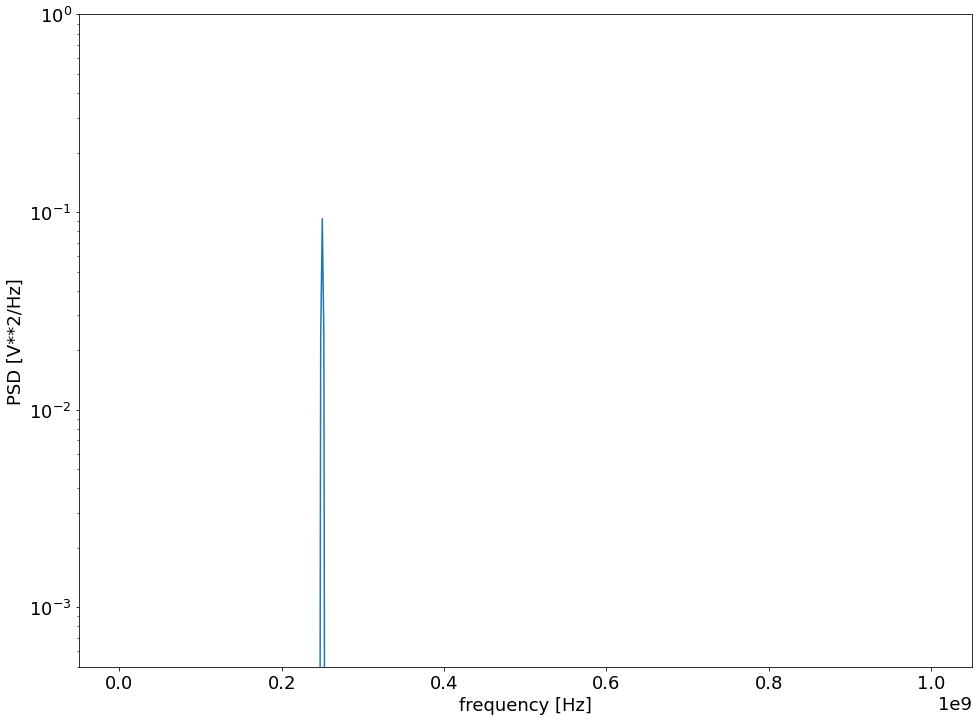

In [ ]:
f, Pxx_den = signal.welch(slice1, sampling_frequency, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

#### FFT on ADC_02

##### DFT

In [ ]:
y2 = df2['var_names']
c2 = fftpack.fft(y2)  # returns DFT of real or complex sequences
f2 = np.fft.fftfreq(len(y2),time_step)
print(c2.shape)

(16384,)


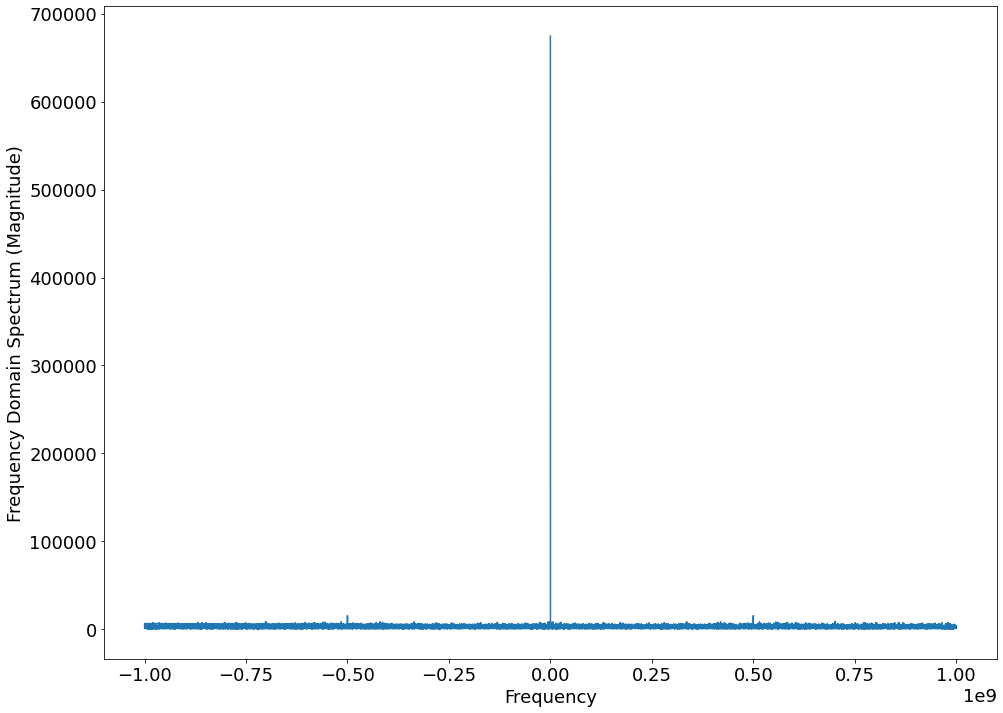

In [ ]:
# scale factor for y-axis in terms of 1x10^6
plt.plot(f2,abs(c2))
plt.xlabel('Frequency')
plt.ylabel('Frequency Domain Spectrum (Magnitude)')
plt.show()

##### Inverse Fourier Transform

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


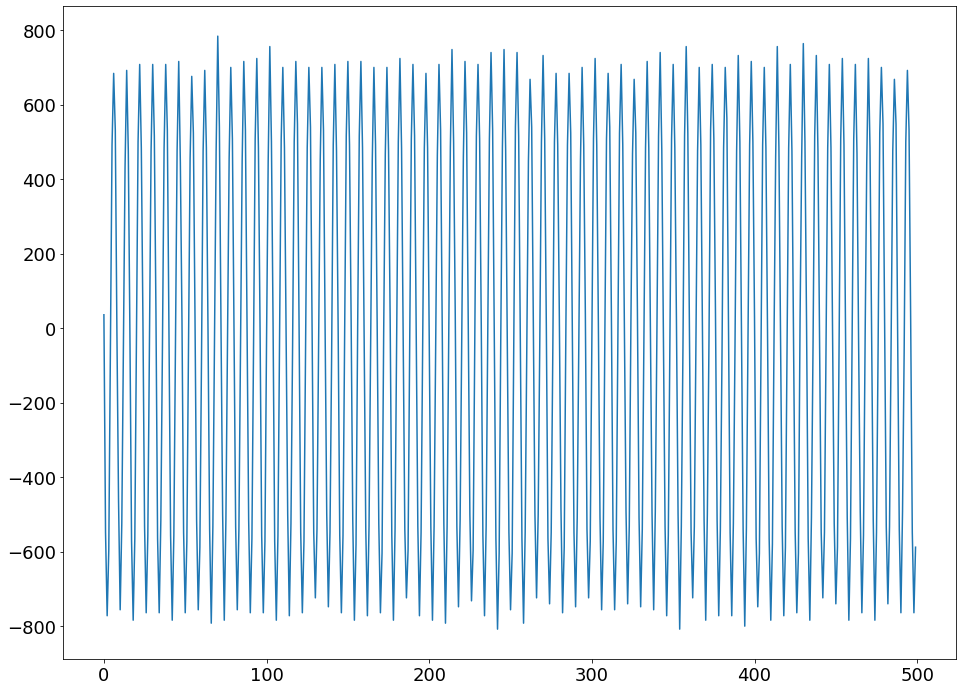

In [ ]:
# Inverse Fourier Transform
y2_forInversefft = fftpack.ifft(c)
plt.plot(y2_forInversefft[:500])
plt.show()

##### Spectogram 

In [ ]:
df2 = df2['var_names']
slice2 = np.array(df2, dtype=float)
slice2.shape

(16384,)

In [ ]:
freqs, times, Sx = signal.spectrogram(slice2, fs=sampling_frequency, nperseg=1024, noverlap=512  , window='hanning')

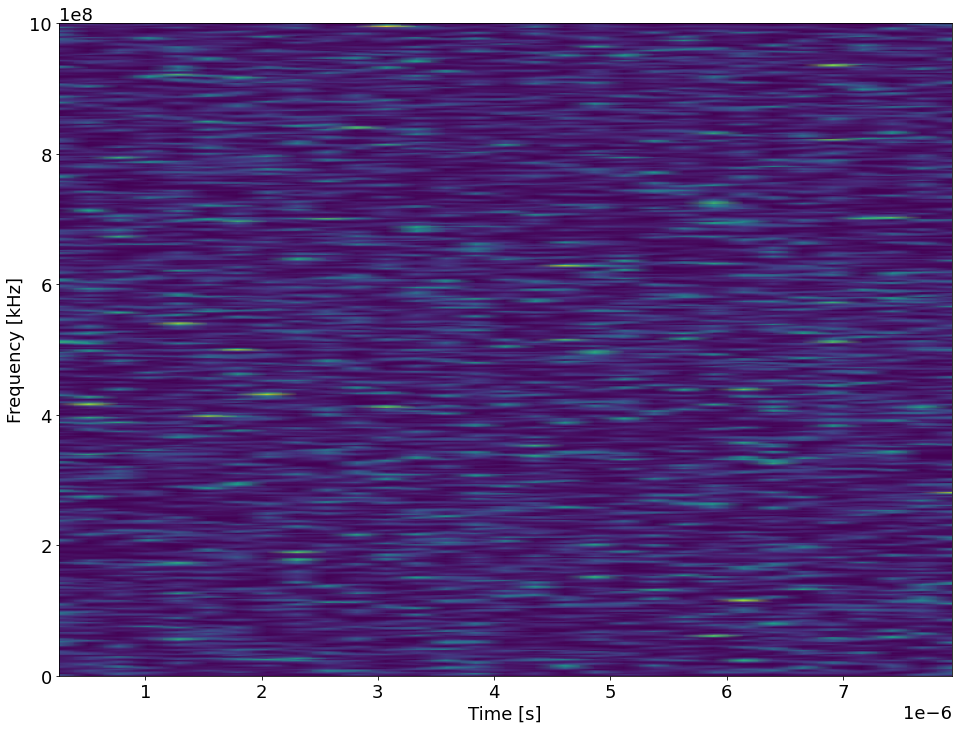

In [ ]:
f, ax = plt.subplots()
ax.pcolormesh(times, freqs, Sx, shading='gouraud')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

##### Power Spectral Density 

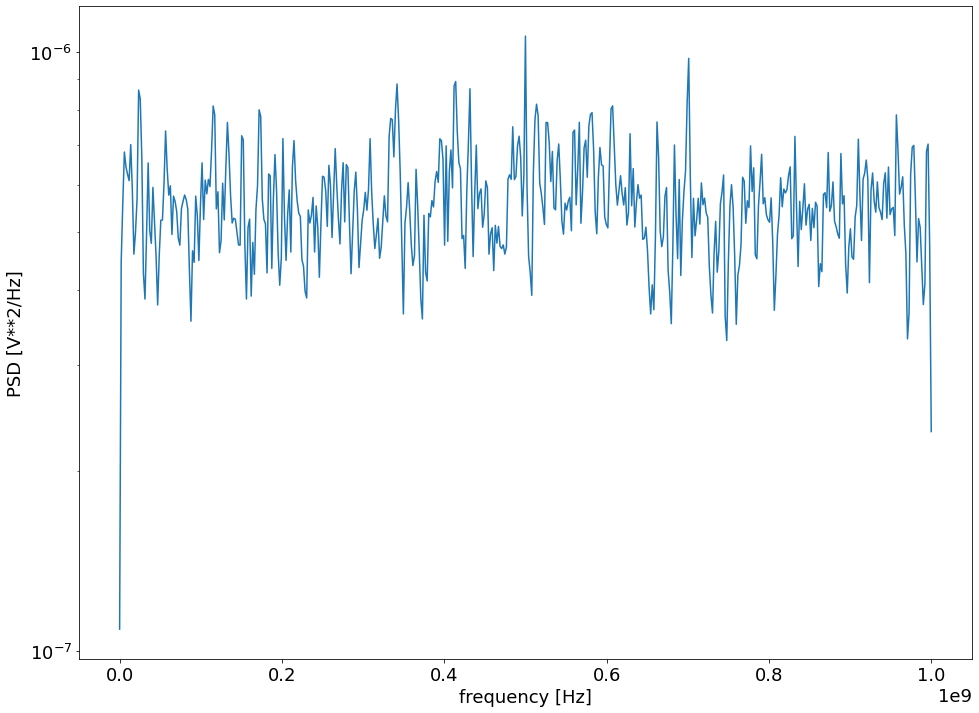

In [ ]:
f, Pxx_den = signal.welch(slice2, sampling_frequency, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

#### FFT on ADC_03

In [ ]:
y3 = df3['var_names']
c3 = fftpack.fft(y3)  # returns DFT of real or complex sequences
f3 = np.fft.fftfreq(len(y3),time_step)
print(c3)

[-264896.           -0.j            3699.55216478-5960.26105478j
    5613.50613976+5175.81110049j ...    5045.36159089-4082.91574437j
    5613.50613976-5175.81110049j    3699.55216478+5960.26105478j]


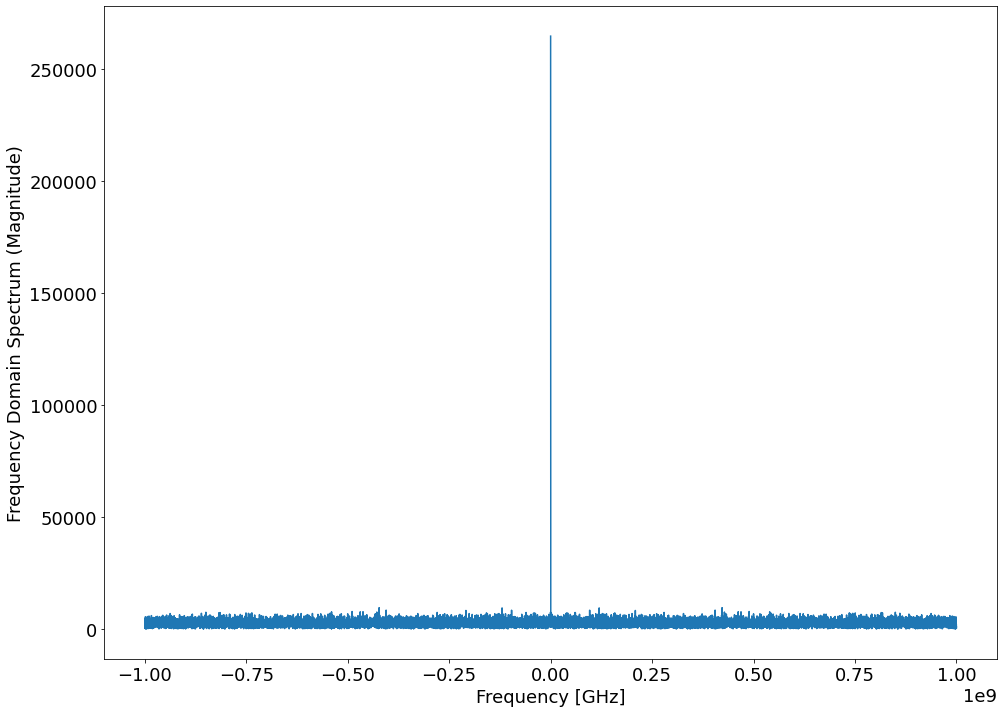

In [ ]:
# scale factor for y-axis in terms of 1x10^6
plt.plot(f3,abs(c3))
plt.xlabel('Frequency [GHz]')
plt.ylabel('Frequency Domain Spectrum (Magnitude)')
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


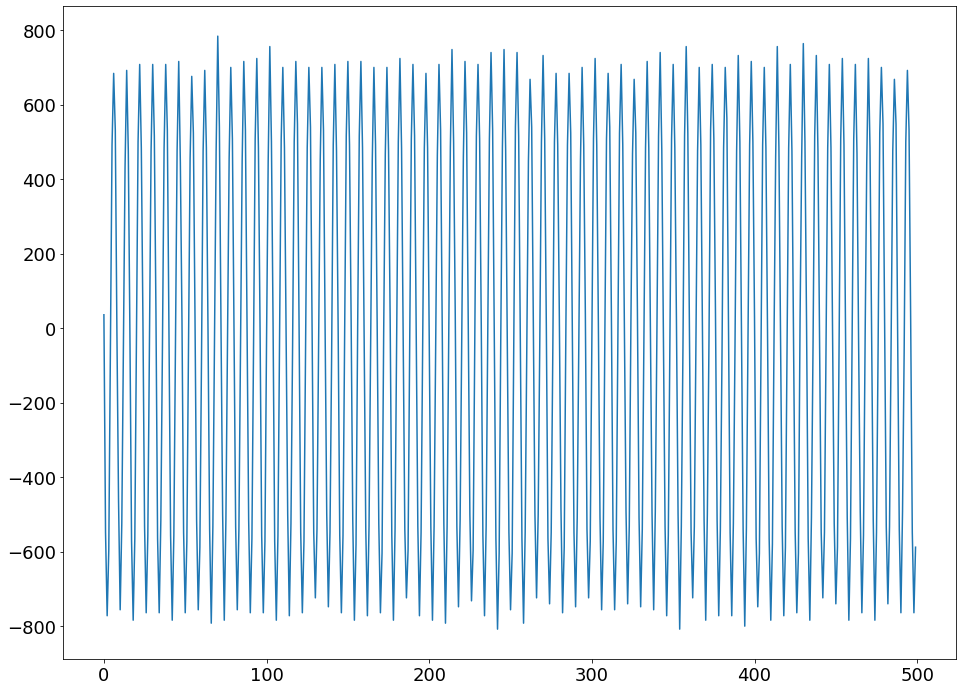

In [ ]:
# Inverse Fourier Transform
y3_forInversefft = fftpack.ifft(c)
plt.plot(y3_forInversefft[:500])
plt.show()

In [ ]:
df3 = df3['var_names']
slice3 = np.array(df3, dtype=float)
slice3.shape
freqs, times, Sx = signal.spectrogram(slice3, fs=sampling_frequency, nperseg=1024, noverlap=512, window='hanning', return_onesided=True)

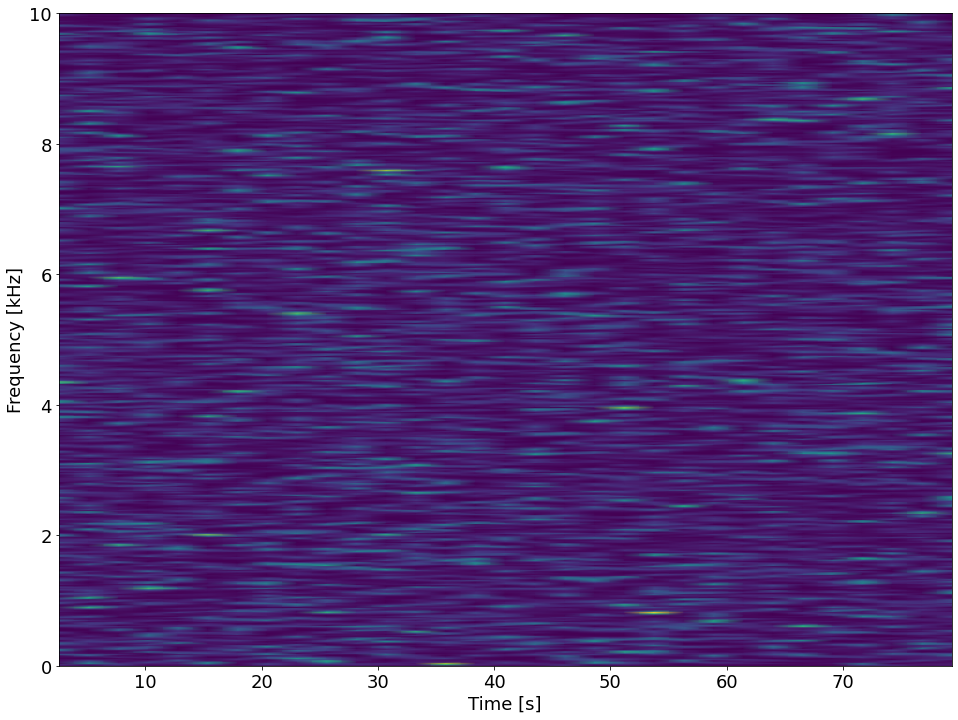

In [ ]:
f, ax = plt.subplots()
ax.pcolormesh(times*10000000, freqs/100000000, Sx, shading='gouraud')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

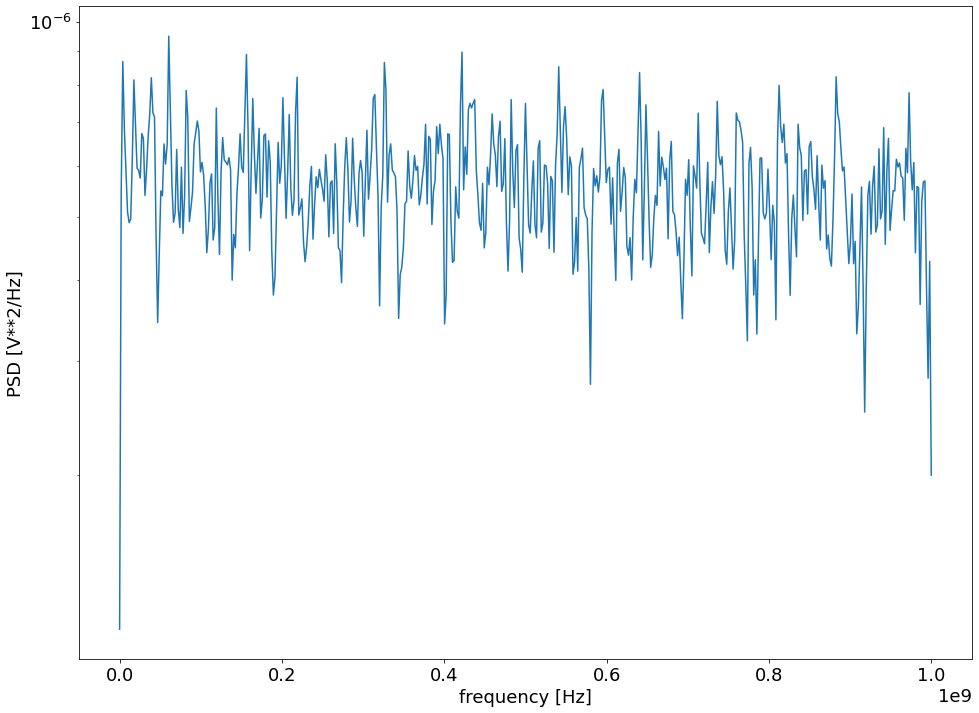

In [ ]:
f, Pxx_den = signal.welch(slice3, sampling_frequency, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

#### FFT on ADC_04

In [ ]:
y4 = df4['var_names']
c4 = fftpack.fft(y4)  # returns DFT of real or complex sequences
f4 = np.fft.fftfreq(len(y4),time_step)
print(c4)

[-318284.           -0.j           -3976.7993163 +6670.79256591j
    1509.4585099 -2280.13158122j ...     718.90187263 +544.479546j
    1509.4585099 +2280.13158122j   -3976.7993163 -6670.79256591j]


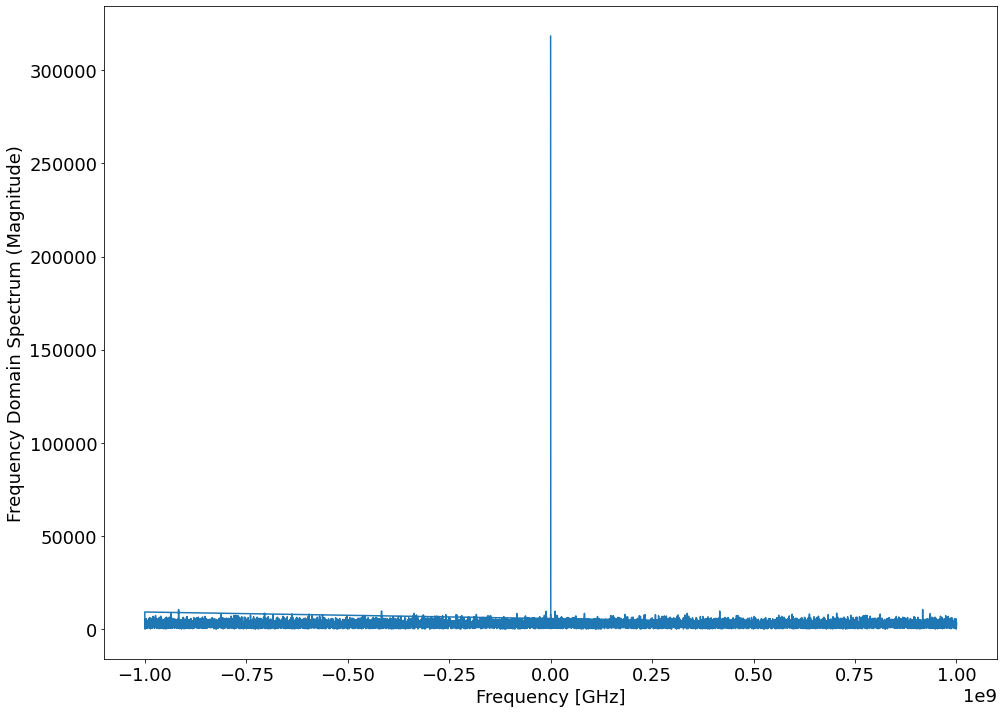

In [ ]:
# scale factor for y-axis in terms of 1x10^6
plt.plot(f4,abs(c4))
plt.xlabel('Frequency [GHz]')
plt.ylabel('Frequency Domain Spectrum (Magnitude)')
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


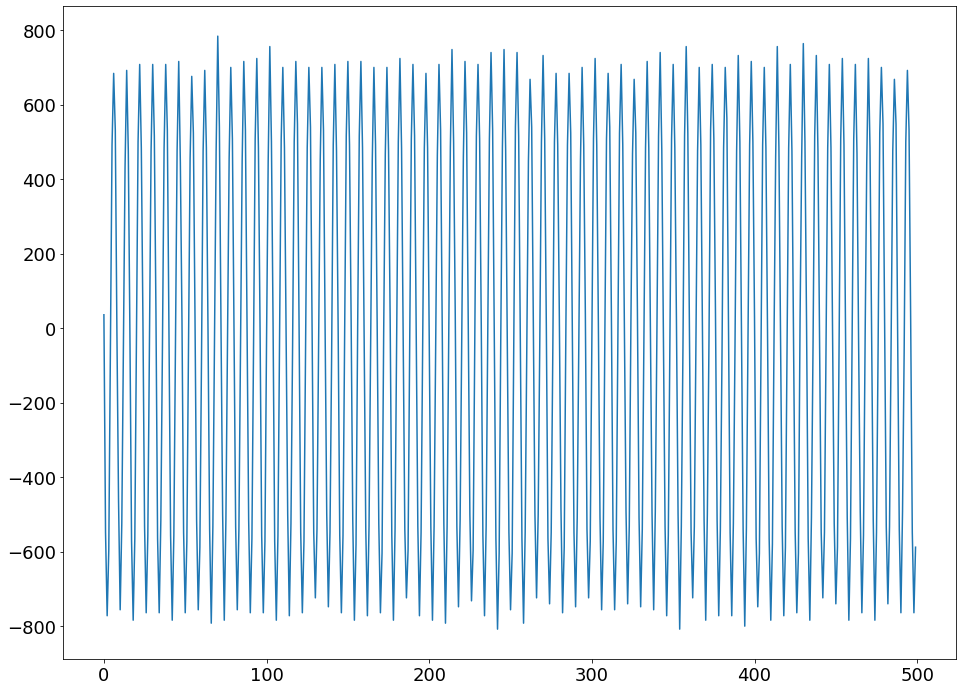

In [ ]:
# Inverse Fourier Transform
y4_forInversefft = fftpack.ifft(c)
plt.plot(y4_forInversefft[:500])
plt.show()

In [ ]:
df4 = df4['var_names']
slice4 = np.array(df4, dtype=float)

freqs, times, Sx = signal.spectrogram(slice4, fs=sampling_frequency, nperseg=1024, noverlap= 512, window='hanning', return_onesided=True)

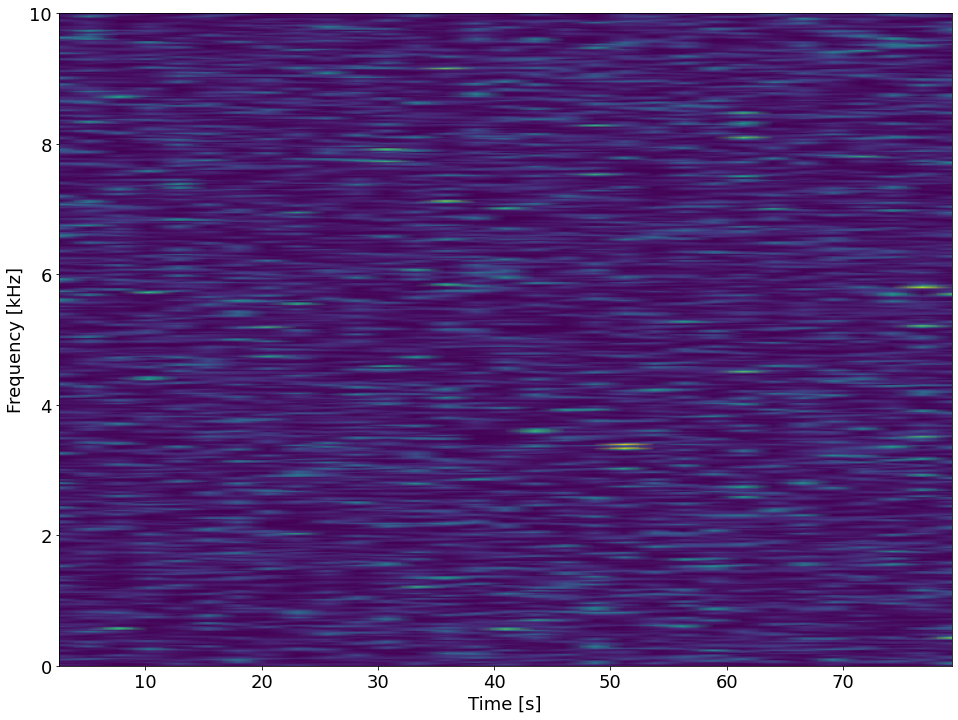

In [ ]:
f, ax = plt.subplots()
ax.pcolormesh(times*10000000, freqs/100000000, Sx, shading='gouraud')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

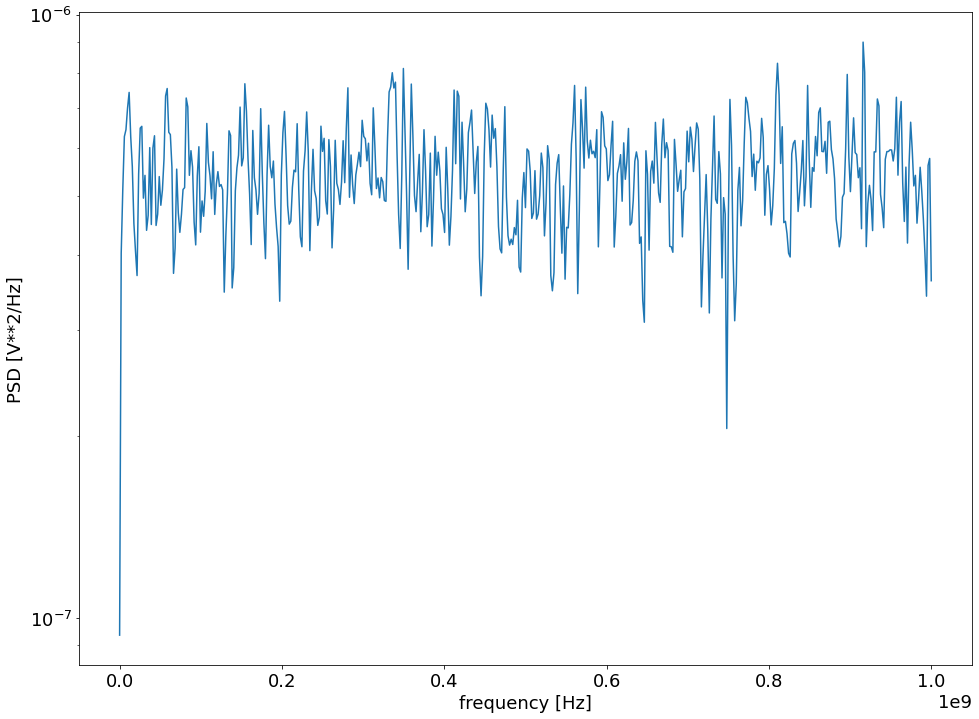

In [ ]:
f, Pxx_den = signal.welch(slice4, sampling_frequency, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

#### Cross Spectral Density of 2 Stationary Waves (from Data1 and Data2)

##### CSD
Displaying a plot of Power of a pair of 2 stationary signals (from Data1 and Data2) multiplied in frequency domain. Both the signals are uncorrelated

In [ ]:
# Reading Data from 2nd File 
dataframe2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/CSIRO/iladata_m10dBm.csv")
data2_adc_01 = dataframe2[['Sample in Buffer', 'Sample in Window', 'TRIGGER', 'design_1_i/usp_rf_data_converter_0_m20_axis_tdata[63:0]', 'design_1_i/usp_rf_data_converter_0_m20_axis_tvalid']]
data2_adc_01 = data2_adc_01.drop(dataframe.index[[0]])
data2_adc_01 = data2_adc_01.reset_index(drop = True)
data2_d1 = data_signed_int(data2_adc_01, 'design_1_i/usp_rf_data_converter_0_m20_axis_tdata[63:0]')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
data2_d1 = data2_d1['var_names']
slice_data2_df1 = np.array(data2_d1, dtype=float)

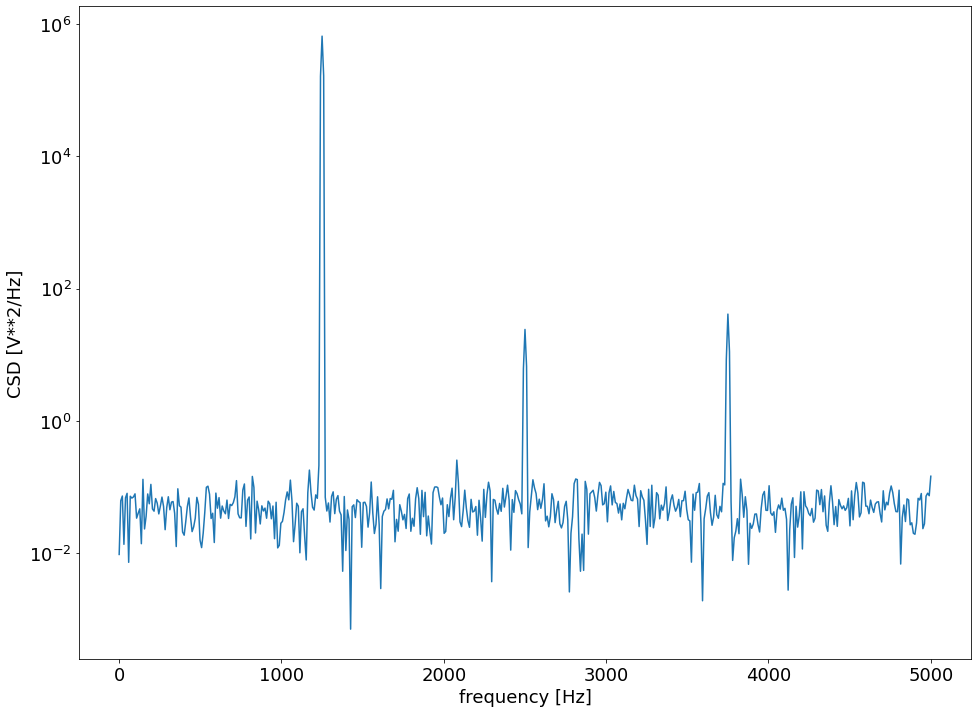

In [ ]:
f, Pxy = signal.csd(slice1, slice_data2_df1, fs, nperseg=1024, noverlap= 512)
plt.semilogy(f, np.abs(Pxy))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

A CSD with a spike at some frequency (F) Hertz indicates that the pair of signals is periodically correlated every 1/F seconds. The correlation may be due to a resonant frequency at F.

##### Serial Correlation

In [ ]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return int(result[result.size/2:])

In [ ]:
#autocorr(df1)